In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import disrnn
import rnn_utils
from rnn_utils import DatasetRNN

# Load Data

In [2]:
matDf = loadmat('..\data\data_for_Meike.mat')['data']
features = matDf.dtype.names
df = pd.DataFrame(np.squeeze(np.array(matDf.tolist())).T, columns=features).drop(columns=['label','Spcorrect1', 'Spcorrect2', 'Snoise']).sort_values(by=['subject', 'trial'])
df

,subject,block,trial,dtheta,type,Pchoice,Preport,Pacc,Schoice,Sreport,Sacc,Srt1,Srt2,select
0,1.0,1.0,1.0,0.18,2.0,-1.0,5.0,0.0,1.0,3.0,1.0,0.907,2576.0,-1.0
1,1.0,1.0,2.0,-0.11,2.0,-1.0,6.0,1.0,-1.0,4.0,1.0,0.380,1483.0,-1.0
2,1.0,1.0,3.0,-0.27,1.0,-1.0,3.0,1.0,-1.0,6.0,1.0,0.388,940.0,1.0
3,1.0,1.0,4.0,0.18,2.0,1.0,6.0,1.0,1.0,5.0,1.0,0.399,1505.0,-1.0
4,1.0,1.0,5.0,0.05,1.0,-1.0,3.0,0.0,1.0,1.0,1.0,1.234,665.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,30.0,4.0,252.0,-0.13,2.0,1.0,3.0,0.0,-1.0,4.0,1.0,0.475,1640.0,1.0
7676,30.0,4.0,253.0,0.13,1.0,1.0,5.0,1.0,-1.0,2.0,0.0,0.507,1655.0,-1.0
7677,30.0,4.0,254.0,0.05,2.0,-1.0,3.0,0.0,-1.0,4.0,0.0,0.308,1790.0,1.0
7678,30.0,4.0,255.0,0.05,2.0,1.0,4.0,1.0,-1.0,3.0,0.0,1.449,1584.0,-1.0


In [8]:
n_subjects = np.unique(df['subject']).shape[0]
n_blocks = np.unique(df['block']).shape[0]
n_trials = int(np.unique(df['trial']).shape[0]/(n_blocks*2)) # 2 partners

# Partner 1
df1 = df[df['type'] == 1]
confidence1 = np.zeros((n_blocks, n_trials, n_subjects))

for i, subject in enumerate(np.unique(df['subject'])):
    confidence1[:, :, i] = df1[df1['subject'] == subject]['Sreport'].values.reshape(n_blocks, n_trials)

confidence1 = confidence1.astype(int)

# Partner 2
df2 = df[df['type'] == 2]
confidence2 = np.zeros((n_blocks, n_trials, n_subjects))

for i, subject in enumerate(np.unique(df2['subject'])):
    confidence2[:, :, i] = df2[df2['subject'] == subject]['Sreport'].values.reshape(n_blocks, n_trials)

confidence2 = confidence2.astype(int)

mean_subjects1 = np.mean(confidence1, axis=2)
mean_subjects2 = np.mean(confidence2, axis=2)

In [10]:
mean_subjects1.shape    

(4, 32)

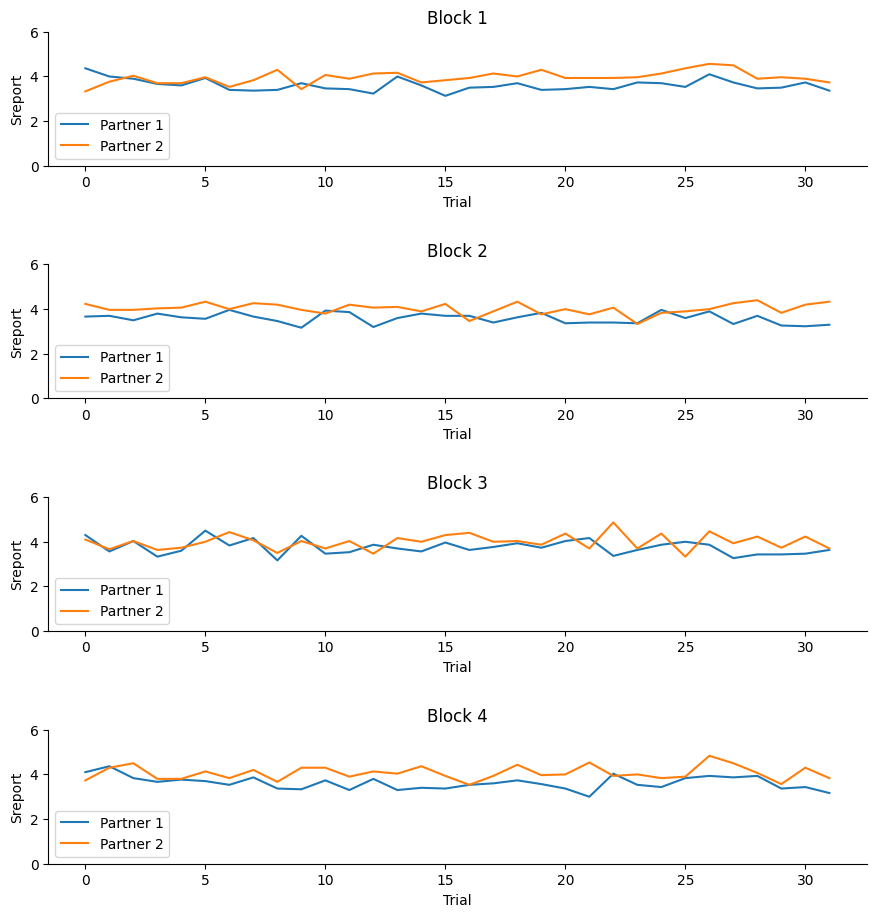

In [24]:
# Plot mean Sreport for each block
fig, ax = plt.subplots(4, figsize=(10, 10))
fig.tight_layout(pad=5)
for i in range(n_blocks):
    ax[i].plot(mean_subjects1[i, :], label='Partner 1')
    ax[i].plot(mean_subjects2[i, :], label='Partner 2')
    ax[i].legend()
    ax[i].set_ylim([0, 6])
    ax[i].set_xlabel('Trial')
    ax[i].set_ylabel('Sreport')
    ax[i].set_title('Block {}'.format(i+1))
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

Text(0, 0.5, 'mean Sreport across subjects and blocks')

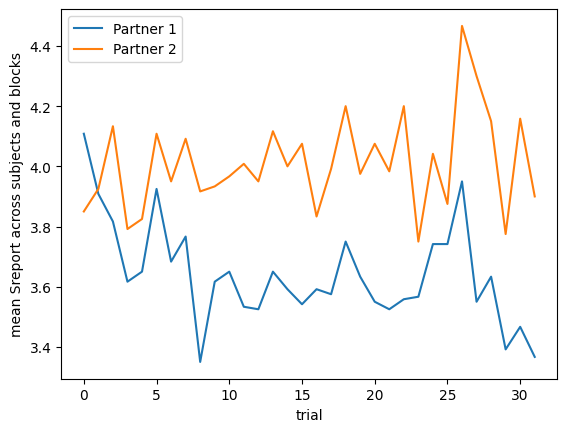

In [34]:
# # Plot mean Sreport across trials and type
# plt.figure()
# plt.plot(np.mean(mean_blocks1, axis=1), label='Partner 1')
# plt.plot(np.mean(mean_blocks2, axis=1), label='Partner 2')
# plt.legend()
# plt.xlabel('Trial')
# plt.ylabel('Mean Sreport across subjects and blocks')

Model outputs

In [ ]:
shape = (132, 29, 2)

model_outputs_partner1 = np.loadtxt("..\data\model_outputs_partner1.csv", delimiter=",")
model_outputs_partner1 = model_outputs_partner1.reshape(shape)
predictions_partner1 = np.argmax(model_outputs_partner1, axis=2) # axis ?

model_outputs_partner2 = np.loadtxt("..\data\model_outputs_partner2.csv", delimiter=",")
model_outputs_partner2 = model_outputs_partner2.reshape(shape)
predictions_partner2 = np.argmax(model_outputs_partner2, axis=2) # axis ?

# remove padded rows
border = n_trials
indices_xsTrain = np.arange(0, n_blocks * border, border)

predictions_partner2 = np.delete(predictions_partner2, indices_xsTrain, axis=0)
predictions_partner2 = np.reshape(predictions_partner2, (n_blocks, n_trials, n_subjects-1))

predictions_partner1 = np.delete(predictions_partner1, indices_xsTrain, axis=0)
predictions_partner1 = np.reshape(predictions_partner1, (n_blocks, n_trials, n_subjects-1))

mean_blocks_partner1 = np.mean(predictions_partner1, axis=0)
mean_blocks_partner2 = np.mean(predictions_partner2, axis=0)

In [48]:
shape = (260, 1, 2)

model_outputs = np.loadtxt("..\data\model_outputs.csv", delimiter=",")
model_outputs = model_outputs.reshape(shape)
model_predictions = np.argmax(model_outputs, axis=2) # axis ?

# remove padded rows
border = n_trials
indices_xsTrain = np.arange(0, n_blocks * border, border)

model_predictions = np.reshape(np.delete(model_predictions, indices_xsTrain, axis=0), 
                               (n_blocks, n_trials, n_subjects-1))
                            
model_outputs_partner1 = xs


Text(0.5, 1.0, 'Model prediction averaged over blocks')

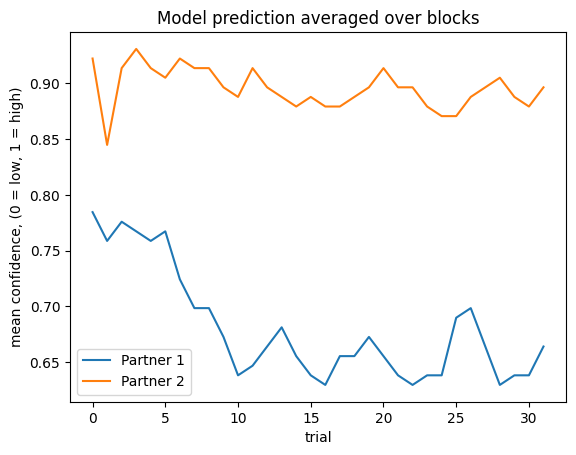

In [50]:
plt.figure()
plt.plot(np.mean(mean_blocks_partner1, axis=1), label='Partner 1')
plt.plot(np.mean(mean_blocks_partner2, axis=1), label='Partner 2')
plt.legend()
plt.xlabel('trial')
plt.ylabel('mean confidence, (0 = low, 1 = high)')
plt.title('Model prediction averaged over blocks')